In [1]:
pip install networkx matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pickle
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from IPython.display import FileLink

Importing data, viewing, and cleaning

In [4]:
#load the dataset from the .pkl file
with open('/Users/FedericoJr/Documents/covid_sample-0.0001.pkl', 'rb') as file:
    data = pickle.load(file)

#convert to pd
if not isinstance(data, pd.DataFrame):
    data = pd.DataFrame(data)

#view first row – change max columns to display all info 
pd.set_option('display.max_columns', None)
print(data.head(1))

                   tweetid               userid      screen_name  \
29075  1440152419048955908  1389342585823584263  josephc14074803   

                                 date lang location place_id place_url  \
29075  Tue Sep 21 03:14:28 +0000 2021   en      NaN      NaN       NaN   

      place_type place_name place_full_name place_country_code place_country  \
29075        NaN        NaN             NaN                NaN           NaN   

      place_bounding_box                                               text  \
29075                NaN  Employers Are Baffled as U.S. Benefits End and...   

      extended coord  reply_userid reply_screen  reply_statusid tweet_type  \
29075      yes   NaN           NaN          NaN             NaN   original   

       friends_count  listed_count  followers_count  favourites_count  \
29075            582           1.0              298              1161   

       statuses_count  verified                   hashtag  \
29075            2460     Fal

In [5]:
#view headers
print(data.columns)

Index(['tweetid', 'userid', 'screen_name', 'date', 'lang', 'location',
       'place_id', 'place_url', 'place_type', 'place_name', 'place_full_name',
       'place_country_code', 'place_country', 'place_bounding_box', 'text',
       'extended', 'coord', 'reply_userid', 'reply_screen', 'reply_statusid',
       'tweet_type', 'friends_count', 'listed_count', 'followers_count',
       'favourites_count', 'statuses_count', 'verified', 'hashtag',
       'urls_list', 'profile_pic_url', 'profile_banner_url', 'display_name',
       'date_first_tweet', 'account_creation_date', 'rt_urls_list',
       'mentionid', 'mentionsn', 'rt_screen', 'rt_userid', 'rt_text',
       'rt_hashtag', 'rt_qtd_count', 'rt_rt_count', 'rt_reply_count',
       'rt_fav_count', 'rt_tweetid', 'rt_location', 'qtd_screen', 'qtd_userid',
       'qtd_text', 'qtd_hashtag', 'qtd_qtd_count', 'qtd_rt_count',
       'qtd_reply_count', 'qtd_fav_count', 'qtd_tweetid', 'qtd_urls_list',
       'qtd_location', 'sent_vader', 'token', 'm

In [6]:
#drop all unecessary headers
relevantHeaders = ['state', 'text']
revisedData = data[relevantHeaders]
#print(revisedData)

#drop all empty datasets
revisedData = revisedData.dropna(subset=['state'])
revisedData = revisedData.dropna(subset=['text'])

#check
print(revisedData)
print(revisedData.head(10))

       state                                               text
126940    OH  @Jim_Jordan YOU’RE A LIAR! You know it’s been ...
49444     MD  Global report: WHO in talks with Russia over C...
23398     PA  If when you get up in the morning you don't ha...
11276     CA  RT @aginnt: An estimated 100,000 protestors de...
105941    VA  RT @DAVIDprice24: 291k covid cases yesterday. ...
...      ...                                                ...
10623     NJ  RT @BenjaminNorton: This map says everything a...
26748     CA  RT @mccaffreyr3: Trump is the most UNEDUCATED ...
43380     VA  RT @fred_guttenberg: THIS👏👏👏👏👏  For those who ...
47554     CO  Wy Leg prohibits insurers from denying the unv...
11663     AZ  RT @MCHammer: Pandemic,pandemic then pandemic ...

[31858 rows x 2 columns]
       state                                               text
126940    OH  @Jim_Jordan YOU’RE A LIAR! You know it’s been ...
49444     MD  Global report: WHO in talks with Russia over C...
23398     PA  

Creating a sentiment dictionary

In [7]:
#keywords to stem for
keywordDict = ['anxiety', 'depress', 'sad', 'angry', 'cry', 'suicide', 'suicidal', 'kms', 'fml', 'anxious', 'kill']
keywordDictLength = len(keywordDict)
# print(keywordDictLength)

#adding columns to dataset
for word in keywordDict:
    revisedData[word] = revisedData['text'].apply(lambda x: x.lower().split().count(word))
    
print(revisedData.head(10))

       state                                               text  anxiety  \
126940    OH  @Jim_Jordan YOU’RE A LIAR! You know it’s been ...        0   
49444     MD  Global report: WHO in talks with Russia over C...        0   
23398     PA  If when you get up in the morning you don't ha...        0   
11276     CA  RT @aginnt: An estimated 100,000 protestors de...        0   
105941    VA  RT @DAVIDprice24: 291k covid cases yesterday. ...        0   
17754     MA  As someone who’s been away from my parents thr...        0   
38681     FL  @TheView @CawthornforNC Then why is he politic...        0   
97467     TX  RT @danielsgoldman: August 15 is a Saturday th...        0   
24167     MS  RT @AndrewRantAG: I can’t take much more of th...        0   
93478     IN  RT @JRubinBlogger: Just think: If R's had remo...        0   

        depress  sad  angry  cry  suicide  suicidal  kms  fml  anxious  kill  
126940        0    0      0    0        0         0    0    0        0     0  
49444

Creating frequency counts

In [8]:
#count the number of tweets for each state
tweetCounts = revisedData['state'].value_counts()
#sort based on counts
sorted_states = tweetCounts.index.tolist()[:50]
states = sorted_states

#count the number of tweets for each keyword
keywordCounts = revisedData[keywordDict].sum().sort_values(ascending=False)
sorted_keywords = keywordCounts.index.tolist()
keywordDict = sorted_keywords

Creating a graph

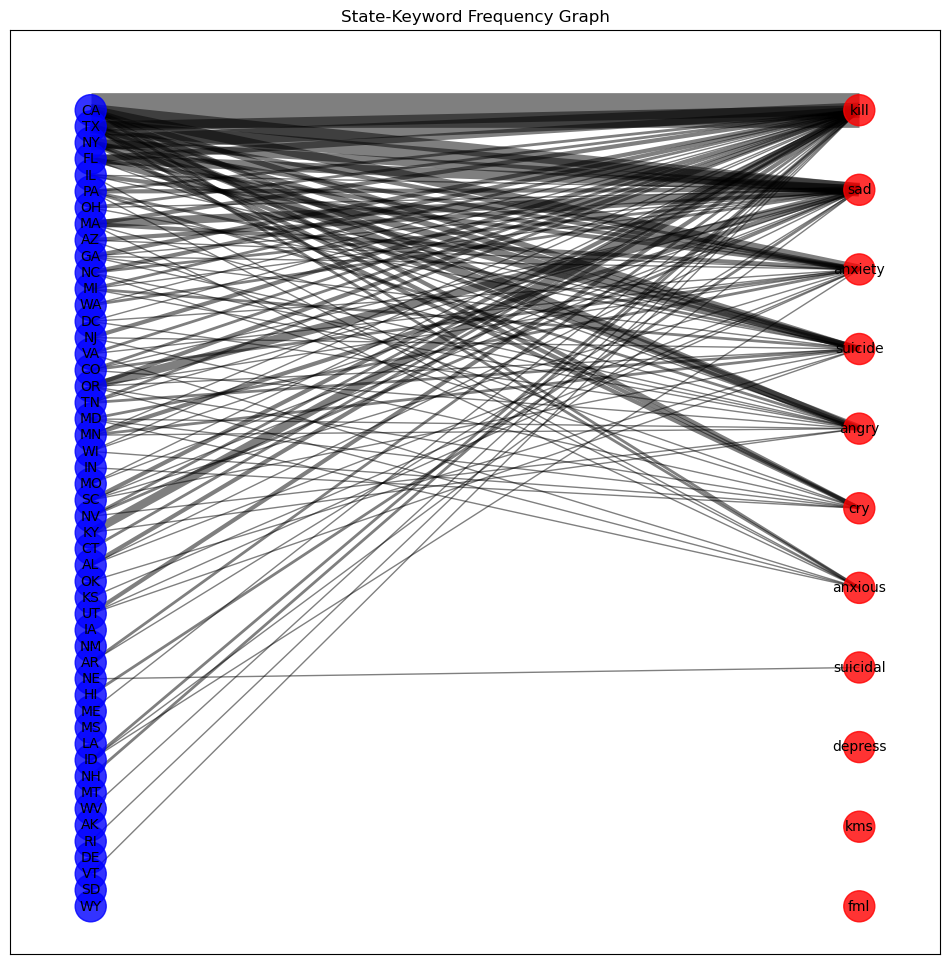

/Users/FedericoJr/Downloads/graph.pdf

In [9]:
#create a graph
G = nx.Graph()

#add state nodes
# states = revisedData['state'].unique()
G.add_nodes_from(states, type='state')

#add keyword nodes
G.add_nodes_from(keywordDict, type='keyword')

#add edges with weights based on keyword frequency
for state in states:
    stateData = revisedData[revisedData['state'] == state]
    for word in keywordDict:
        frequency = stateData[word].sum()
        if frequency > 0:
            G.add_edge(state, word, weight=frequency)

#define node colors
color_map = []
for node in G:
    if node in states:
        color_map.append('blue')  # States are blue
    else:
        color_map.append('red')   # Keywords are red

#define edge thickness
edges = G.edges(data=True)
edge_widths = [G[u][v]['weight'] for u, v, d in edges]


#manually set positions
pos = {}
#stack state nodes vertically
y_state = 1.0
y_step_state = 2.0 / (len(states) - 1)
for i, state in enumerate(states):
    pos[state] = (-1, y_state - i * y_step_state)

#stack keyword nodes vertically to the right of state nodes
y_keyword = 1.0
y_step_keyword = 2.0 / (len(keywordDict) - 1)
for i, keyword in enumerate(keywordDict):
    pos[keyword] = (1, y_keyword - i * y_step_keyword)

#draw the graph
plt.figure(figsize=(12, 12))

nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=500, alpha=0.8)
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5)

plt.title('State-Keyword Frequency Graph')
# plt.show()

#save the figure
pdf_filename = 'graph.pdf'
plt.savefig(pdf_filename, bbox_inches='tight', dpi=300)
plt.show()

FileLink(pdf_filename)

Creating an adjacency matrix

Matrix of keyword frequencies per state:
[[25  9  7  4  4  3  2  0  0  0  0]
 [ 7 10  3  4  6  3  2  0  0  0  0]
 [11  6  3  5  3  3  0  0  0  0  0]
 [ 5  7  3  4  1  0  0  0  0  0  0]
 [ 0  1  3  1  0  0  1  0  0  0  0]
 [ 2  3  0  2  2  0  1  0  0  0  0]
 [ 2  1  0  1  0  0  0  0  0  0  0]
 [ 3  6  3  0  1  0  1  0  0  0  0]
 [ 0  3  1  0  0  1  0  0  0  0  0]
 [ 3  1  1  1  1  0  0  0  0  0  0]
 [ 3  2  0  0  1  1  0  0  0  0  0]
 [ 2  1  0  2  1  0  0  0  0  0  0]
 [ 1  2  0  0  0  0  0  0  0  0  0]
 [ 1  0  1  0  1  0  0  0  0  0  0]
 [ 3  0  0  1  0  1  0  0  0  0  0]
 [ 2  0  1  0  0  0  1  0  0  0  0]
 [ 2  1  2  0  1  0  0  0  0  0  0]
 [ 3  6  1  1  0  1  1  0  0  0  0]
 [ 2  1  0  2  0  0  0  0  0  0  0]
 [ 0  0  2  0  1  1  1  0  0  0  0]
 [ 1  3  0  2  1  0  0  0  0  0  0]
 [ 1  1  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0]
 [ 1  1  0  0  0  0  0  0  0  0  0]
 [ 3  1  1  1  0  0  0  0  0  0  0]
 [ 2  2  0  0  1  0  0  0  0  0  0]
 [ 6  0  0  0  1  0  0 

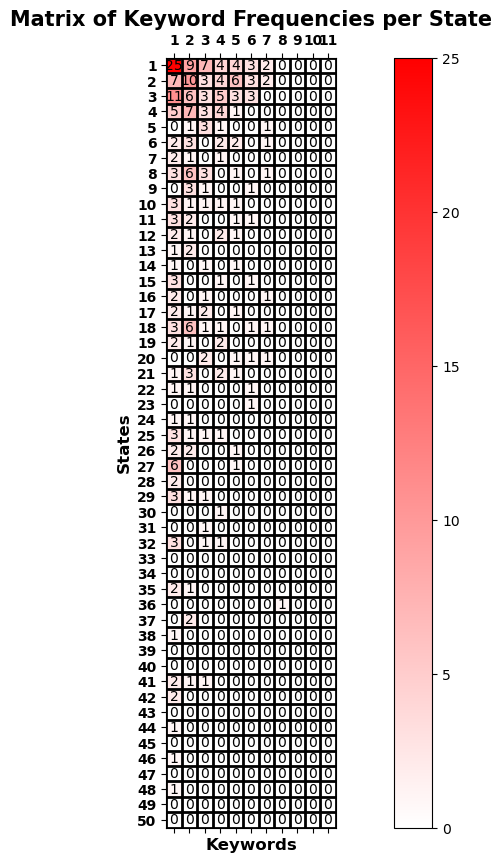

/Users/FedericoJr/Downloads/matrix.pdf

In [10]:
#create the matrix
matrix = np.zeros((len(states), len(keywordDict)), dtype=int)

#fill matrix with frequency values
stateIndex = {state: i for i, state in enumerate(states)}
keywordIndex = {keyword: i for i, keyword in enumerate(keywordDict)}

for state in states:
    for keyword in keywordDict:
        frequency = revisedData[revisedData['state'] == state][keyword].sum()
        matrix[stateIndex[state], keywordIndex[keyword]] = frequency

#PRINT MATRIX
print("Matrix of keyword frequencies per state:")
print(matrix)


#DRAW MATRIX
#custom colorbar
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["white", "red"])


fig, ax = plt.subplots(figsize=(15, 10))
cax = ax.matshow(matrix, cmap=cmap)

#add colorbar
plt.colorbar(cax)

# Set axis labels
ax.set_xticks(np.arange(len(keywordDict)))
ax.set_yticks(np.arange(len(states)))
ax.set_xticklabels(range(1, len(keywordDict) + 1), rotation=0, fontweight='bold')
ax.set_yticklabels(range(1, len(states) + 1), fontweight='bold')

#add labels
for i in range(50):
    for j in range(11):
        ax.text(j, i, matrix[i, j], va='center', ha='center', color='black')

#draw grid lines
ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
ax.set_xticks(np.arange(-.5, len(keywordDict), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(states), 1), minor=True)
ax.tick_params(which='minor', size=0)

plt.xlabel('Keywords', fontsize=12, fontweight='bold')
plt.ylabel('States', fontsize=12, fontweight='bold')
plt.title('Matrix of Keyword Frequencies per State', fontsize=15, fontweight='bold')

#save the figure
pdf_filename = 'matrix.pdf'
plt.savefig(pdf_filename, bbox_inches='tight', dpi=300)
plt.show()

FileLink(pdf_filename)


# plt.savefig('matrix.pdf', bbox_inches='tight', dpi=300)
# plt.show()